### Multi-Label Topic Classification of News Articles

This was our first implementation just to see what can be achieved with a TF-IDF + LinearSVC hierarchical model.  
We combined the title and content of each article, cleaned the text, and trained a Level 1 classifier to predict the broad category.  
For each Level 1 category, we trained a separate Level 2 classifier to predict the more specific subcategories.  
We did this to evaluate the potential of a traditional machine learning approach before moving on to more advanced models such as BERT.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2


##### Understanding the Data

Loadingf the data

In [43]:
file_path = 'dataset/MN-DS-news-classification.csv'
df = pd.read_csv(file_path)

print("dataset Info")
print(df.info())
print("First 5 Rows")
print(df.head())

dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10917 entries, 0 to 10916
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   data_id           10917 non-null  int64 
 1   id                10917 non-null  object
 2   date              10917 non-null  object
 3   source            10917 non-null  object
 4   title             10917 non-null  object
 5   content           10917 non-null  object
 6   author            7605 non-null   object
 7   url               10917 non-null  object
 8   published         10917 non-null  object
 9   published_utc     10917 non-null  int64 
 10  collection_utc    10917 non-null  int64 
 11  category_level_1  10917 non-null  object
 12  category_level_2  10917 non-null  object
dtypes: int64(3), object(10)
memory usage: 1.1+ MB
None
First 5 Rows
   data_id                                                 id        date  \
0     1809  abcnews--2019-10-31--Virginia 

Basic details of data

In [44]:
print(f"Total number of samples: {len(df)}")
print(f"Available columns: {list(df.columns)}")

# Check for missing values
print("\nMissing Values by Column")
print(df.isnull().sum())


Total number of samples: 10917
Available columns: ['data_id', 'id', 'date', 'source', 'title', 'content', 'author', 'url', 'published', 'published_utc', 'collection_utc', 'category_level_1', 'category_level_2']

Missing Values by Column
data_id                0
id                     0
date                   0
source                 0
title                  0
content                0
author              3312
url                    0
published              0
published_utc          0
collection_utc         0
category_level_1       0
category_level_2       0
dtype: int64


Seeing how many different labels per category


Number of unique Level 1 categories: 17
category_level_1
society                                      1100
sport                                         907
politics                                      900
science and technology                        800
religion and belief                           800
conflict, war and peace                       800
labour                                        703
health                                        700
education                                     607
human interest                                600
environment                                   600
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
weather                                       400
lifestyle and leisure                         300
arts, culture, entertainment and media        300
Name: count, dtype: int64

Number of unique Level 2 categories: 109
category_level_2
transfe

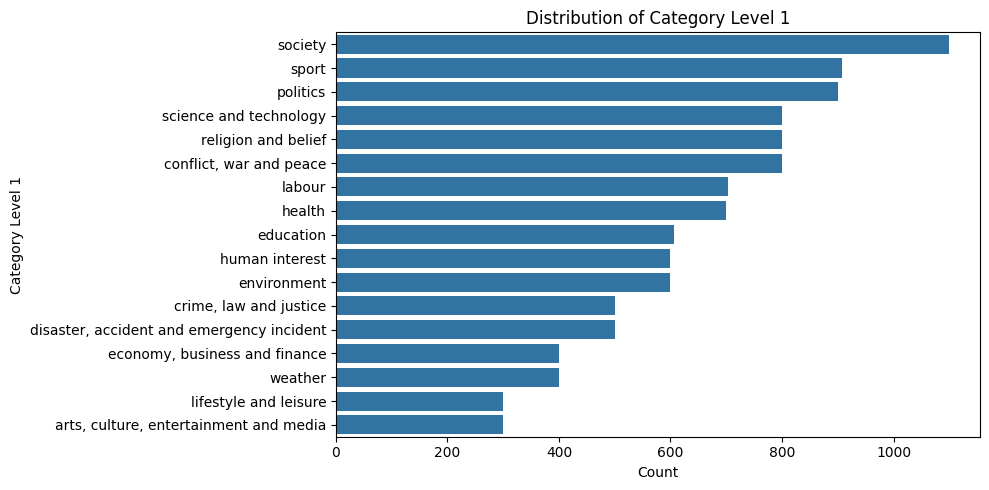

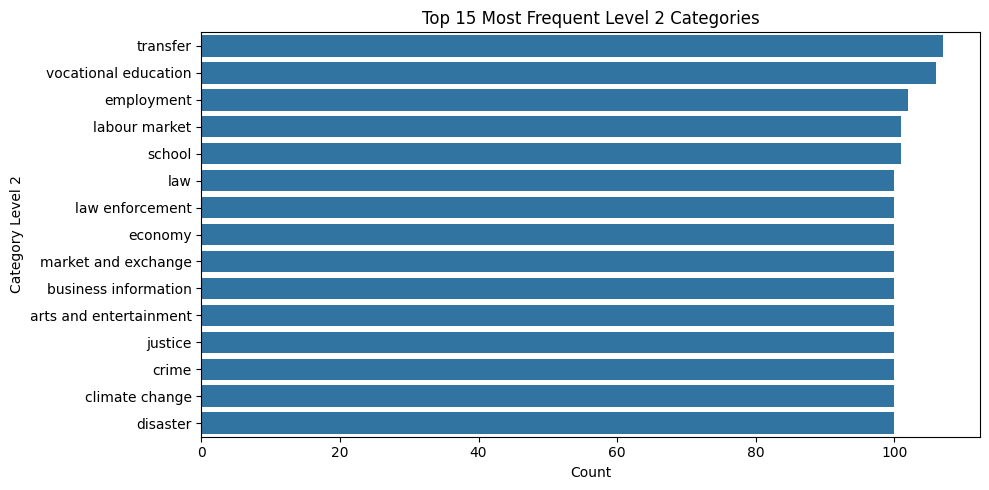

In [45]:
if 'category_level_1' in df.columns:
    print(f"\nNumber of unique Level 1 categories: {df['category_level_1'].nunique()}")
    print(df['category_level_1'].value_counts().head(df['category_level_1'].nunique()))

if 'category_level_2' in df.columns:
    print(f"\nNumber of unique Level 2 categories: {df['category_level_2'].nunique()}")
    print(df['category_level_2'].value_counts().head(df['category_level_2'].nunique()))

### We can remove the graphs or say they were our ai usage
plt.figure(figsize=(10, 5))
sns.countplot(y='category_level_1', data=df, order=df['category_level_1'].value_counts().index)
plt.title("Distribution of Category Level 1")
plt.xlabel("Count")
plt.ylabel("Category Level 1")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_lvl2 = df['category_level_2'].value_counts().head(15)
sns.barplot(y=top_lvl2.index, x=top_lvl2.values)
plt.title("Top 15 Most Frequent Level 2 Categories")
plt.xlabel("Count")
plt.ylabel("Category Level 2")
plt.tight_layout()
plt.show()


Article Length


Text Length Statistics (in words) 
count    10917.000000
mean       649.179170
std        718.128934
min          8.000000
25%        285.000000
50%        479.000000
75%        782.000000
max      11009.000000
Name: text_len, dtype: float64


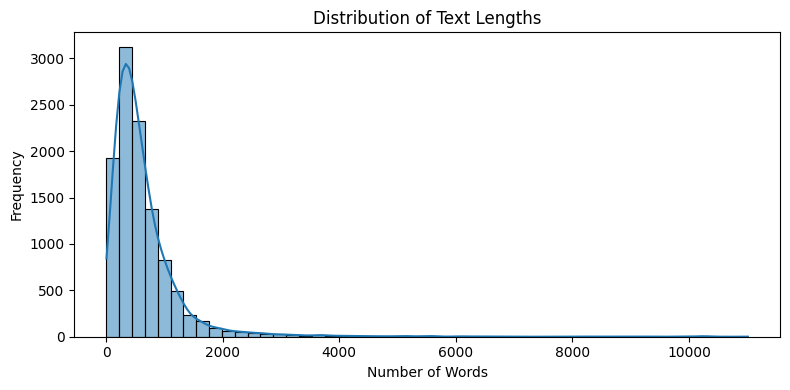

In [46]:
df['text'] = df['title'].fillna('') + " " + df['content'].fillna('')
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))

print("\nText Length Statistics (in words) ")
print(df['text_len'].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df['text_len'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Model

Prepare Data

In [47]:
df['text'] = df['title'].fillna('') + " " + df['content'].fillna('')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

le_lvl1 = LabelEncoder()
le_lvl2 = LabelEncoder()
df['label_lvl1'] = le_lvl1.fit_transform(df['category_level_1'])
df['label_lvl2'] = le_lvl2.fit_transform(df['category_level_2'])

Train and Test Data

In [48]:
X = df['text']
y1 = df['label_lvl1']
y2 = df['label_lvl2']

X_train, X_test, y_train1, y_test1, y_train2, y_test2 = train_test_split(
    X, y1, y2, test_size=0.2, random_state=42, stratify=y1
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train1 = y_train1.reset_index(drop=True)
y_test1 = y_test1.reset_index(drop=True)
y_train2 = y_train2.reset_index(drop=True)
y_test2 = y_test2.reset_index(drop=True)


TF-IDF Vectorization

tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train matrix shape:", X_train_tfidf.shape)


In [49]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF matrix shape:", X_train_tfidf.shape)


TF-IDF matrix shape: (8733, 20000)


Train Level 1

In [50]:
model_lvl1 = LinearSVC(class_weight='balanced', max_iter=5000)
model_lvl1.fit(X_train_tfidf, y_train1)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


Train Level 2

In [51]:
lvl1_classes = le_lvl1.classes_
lvl2_models = {}

for idx, lvl1_label in enumerate(lvl1_classes):
    indices = y_train1[y_train1 == idx].index.tolist()
    
    X_sub = X_train_tfidf[indices, :]
    y_sub = y_train2[indices]
    
    model_lvl2 = LinearSVC(class_weight='balanced', max_iter=10000)
    model_lvl2.fit(X_sub, y_sub)
    
    lvl2_models[idx] = model_lvl2

print("Trained Level 2 classifiers for each Level 1 category.")


Trained Level 2 classifiers for each Level 1 category.


In [52]:
y_pred1 = model_lvl1.predict(X_test_tfidf)
y_pred2 = []

for i, lvl1_pred in enumerate(y_pred1):
    model_lvl2 = lvl2_models[lvl1_pred]
    X_i = X_test_tfidf[i]
    
    X_i = X_i.reshape(1, -1)
    lvl2_pred = model_lvl2.predict(X_i)[0]
    y_pred2.append(lvl2_pred)

y_pred2 = pd.Series(y_pred2)


Evaluation

In [53]:
print("\n=== Level 1 Classification Report ===")
print(classification_report(y_test1, y_pred1, target_names=le_lvl1.classes_))

print("\n=== Level 2 Classification Report ===")
print(classification_report(y_test2, y_pred2, target_names=le_lvl2.classes_))

f1_lvl1 = f1_score(y_test1, y_pred1, average='weighted')
f1_lvl2 = f1_score(y_test2, y_pred2, average='weighted')

print("\nWeighted F1 (Level 1): {:.4f}".format(f1_lvl1))
print("Weighted F1 (Level 2): {:.4f}".format(f1_lvl2))



=== Level 1 Classification Report ===
                                           precision    recall  f1-score   support

   arts, culture, entertainment and media       0.76      0.85      0.80        60
                  conflict, war and peace       0.82      0.88      0.85       160
                   crime, law and justice       0.72      0.75      0.74       100
disaster, accident and emergency incident       0.73      0.67      0.70       100
            economy, business and finance       0.84      0.79      0.81        80
                                education       0.84      0.81      0.82       121
                              environment       0.81      0.87      0.84       120
                                   health       0.83      0.83      0.83       140
                           human interest       0.78      0.75      0.76       120
                                   labour       0.89      0.90      0.89       141
                    lifestyle and leisure      

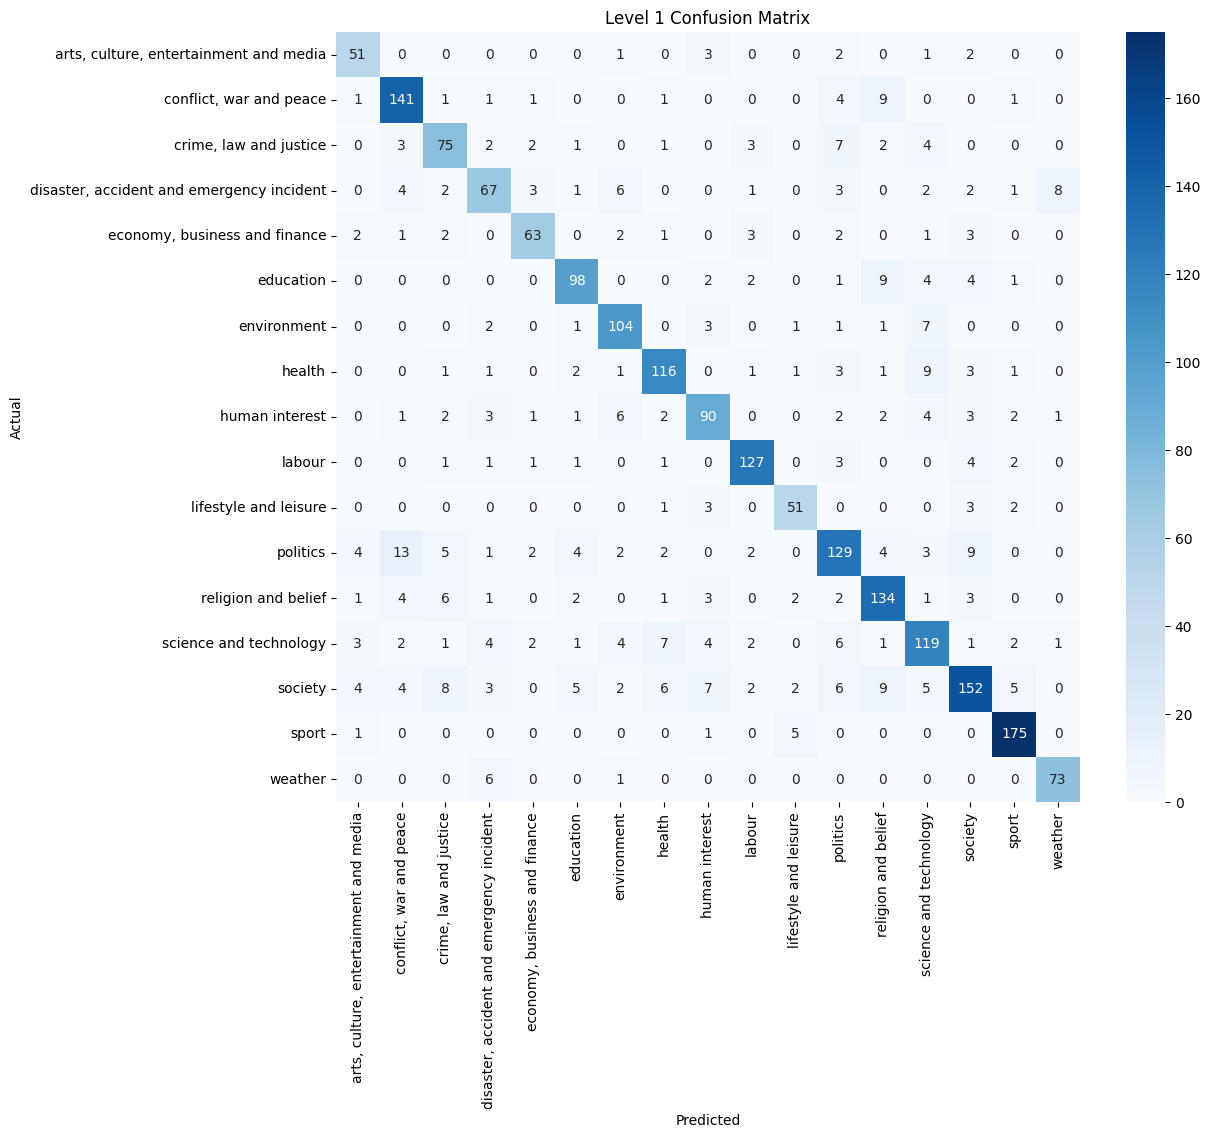

In [54]:
# Level 1
cm1 = confusion_matrix(y_test1, y_pred1)
plt.figure(figsize=(12,10))
sns.heatmap(cm1, annot=True, fmt='d', xticklabels=le_lvl1.classes_, yticklabels=le_lvl1.classes_, cmap='Blues')
plt.title("Level 1 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
